In [3]:
import darts
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%autosave 1 

Autosaving every 1 seconds


In [4]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

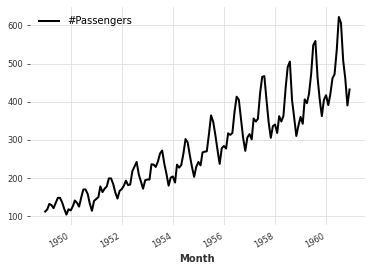

In [5]:
series = AirPassengersDataset().load()
series.plot()

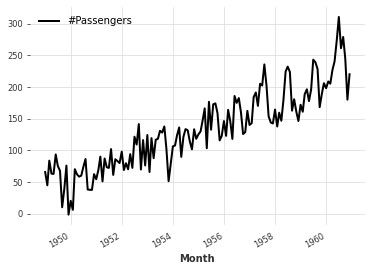

In [8]:
series_noise = TimeSeries.from_times_and_values(series.time_index, np.random.randn(len(series)))
(series / 2 + 20 * series_noise - 10).plot()

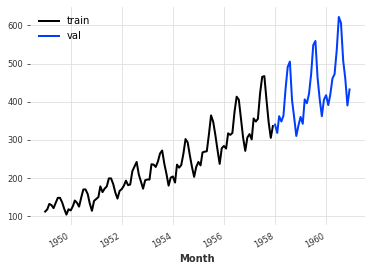

In [13]:
train, val = series[:-36], series[-36:]
train.plot(label='train')
val.plot(label='val')

In [22]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.metrics import mape

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model Prophet obtains MAPE: 9.78%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


In [21]:
thetas = np.linspace(1,10,num=10)
thetas

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [32]:
# Search for the best theta parameter, by trying 50 different values
# thetas = 2 - np.linspace(-10, 10, 50)

thetas = np.linspace(-100, 100, 200)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))       


The MAPE is: 4.40, with theta = -3.517587939698501.


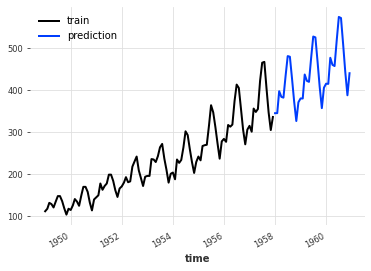

In [33]:
train.plot(label='train')
# val.plot(label='true')
pred_best_theta.plot(label='prediction')

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 7.70%


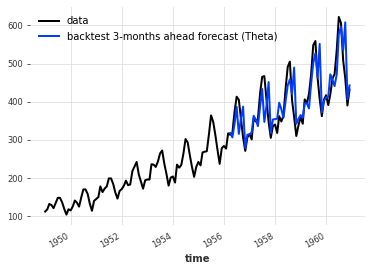

In [34]:
historical_fcast_theta = best_theta_model.historical_forecasts(series,
                                                               start=0.6,
                                                               forecast_horizon=3,
                                                               verbose=True)

series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)')
print('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))

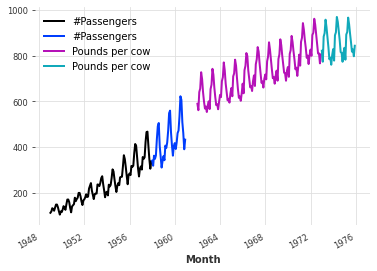

In [35]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot(); val_air.plot()
train_milk.plot(); val_milk.plot()

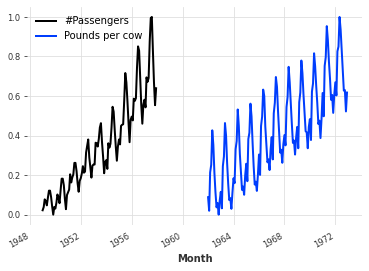

In [36]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [37]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24,
                    output_chunk_length=12,
                    random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

[2022-01-22 14:08:32,222] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-01-22 14:08:32,222] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 194 samples.
[2022-01-22 14:08:32,371] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-01-22 14:08:32,371] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 32-bits; casting model to float32.


  0%|          | 0/50 [00:00<?, ?it/s]

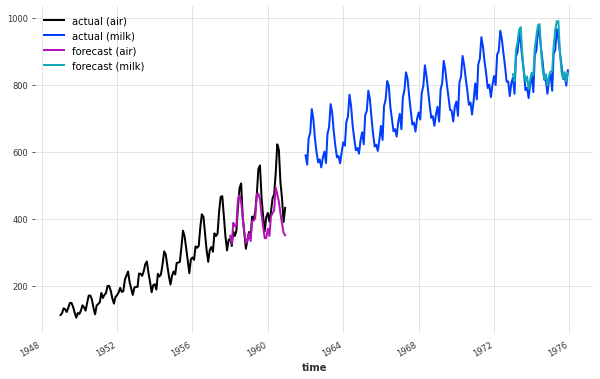

In [47]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10,6))
series_air.plot(label='actual (air)')
series_milk.plot(label='actual (milk)')
pred_air.plot(label='forecast (air)')
pred_milk.plot(label='forecast (milk)')

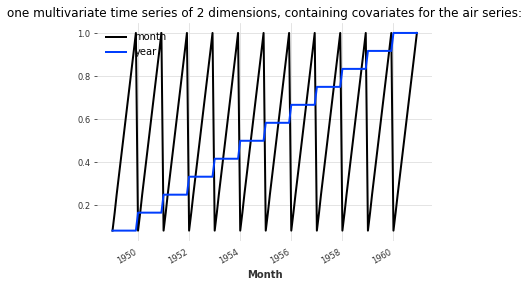

In [49]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate([dt_attr(series_air.time_index, 'month', dtype=np.float32) / 12,
                        (dt_attr(series_air.time_index, 'year', dtype=np.float32) - 1948) / 12],
                       axis='component')

milk_covs = concatenate([dt_attr(series_milk.time_index, 'month', dtype=np.float32) / 12,
                        (dt_attr(series_milk.time_index, 'year', dtype=np.float32) - 1962) / 13],
                       axis='component')

air_covs.plot()
plt.title('one multivariate time series of 2 dimensions, containing covariates for the air series:');

In [50]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72,
                        lags_future_covariates=[-6, 0],
                        model=BayesianRidge())

model.fit([train_air_scaled, train_milk_scaled],
          future_covariates=[air_covs, milk_covs])

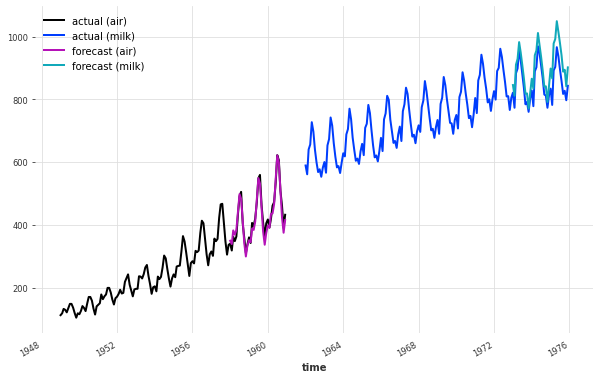

In [51]:
pred_air, pred_milk = model.predict(series=[train_air_scaled, train_milk_scaled],
                                    future_covariates=[air_covs, milk_covs],
                                    n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10,6))
series_air.plot(label='actual (air)')
series_milk.plot(label='actual (milk)')
pred_air.plot(label='forecast (air)')
pred_milk.plot(label='forecast (milk)')

In [52]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.417205491945001, 5.2830416876927755]

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 3.66


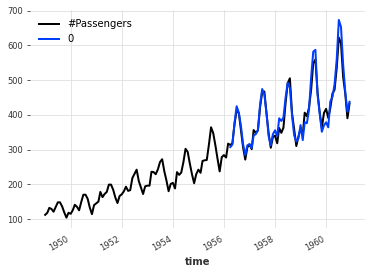

In [53]:
bayes_ridge_model = RegressionModel(lags=72,
                                    lags_future_covariates=[0],
                                    model=BayesianRidge())

backtest = bayes_ridge_model.historical_forecasts(series_air,
                                                  future_covariates=air_covs,
                                                  start=0.6,
                                                  forecast_horizon=3,
                                                  verbose=True)

print('MAPE = %.2f' % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()